# **Machine Learning on Big Data (CN7030) CRWK 22-23 [60% weighting]**
# **Group ID: [1]**
1.   Student 1: Tarun Chand KOGANTI and u2366409
2.   Student 2: Mohammed Akeel VELLATHAMBY ISMAIL and u2344592

---
#####Module leader: **Dr Amin Karami** (a.karami@uel.ac.uk)

If you want to add comments on your group work, please write it here for us:

---

# **Section 1: Design and Build Machine Learning methods on a large-sized data**

---


# **Initiate and Configure Spark**

In [ ]:
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=14b328d769f55479d35fbcd2e43d499a21e7ca773d23b915558bdc23e2e3bf53
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("1").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing required Libraries

In [ ]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, Word2Vec
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


# **Load Data**


### Explain Data shortly here:

Dataset Used :- https://www.kaggle.com/datasets/najzeko/steam-reviews-2020

Dataset contains reviews of various users for various games from the website https://store.steampowered.com/

Each record is a review of a particular user for a particular game.
It contains columns such as :-

**steamid :- User id**

**appid :- Video game id for which the user has written review for**

**review :- Users review for particular video game**

**language :- Reviews language or Games available languages**

**voted_up :- Whether the users recommends the game or not**

**comment_count :- No. of comments for the users review**

**steam_purchase :- Whether the user has purchased the game or recieved for free**

**num_games_owned :- Number of games owned by the user**

**num_reviews :- Number of reviews owned by the user**

**playtime_forever :- Total playtime by the user for the particular game**

**playtime_at_review :- Total playtime by the user for the particular game at the time of writing review**

**and few other columns**

In [ ]:
# The dataset contains reviews column which has new lines whcih are enclosed in quotes and it also has special characters.
# By default spark reads the new line as a new record, hence we are setting the below options - multiLine, escape, quote to read the data properly
video_game_reviews_df = spark.read \
    .option("header", True) \
    .option("quote", "\"") \
    .option("escape", "\"") \
    .option("multiLine", True) \
    .option("inferSchema", True) \
    .csv("/content/drive/My Drive/ML_On_Big_Data/big_reviews.csv")

In [ ]:
video_game_reviews_df.show()

+---+-----+----------------+---------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+
|_c0|appid|recommendationid| language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|
+---+-----+----------------+---------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+---------------

In [ ]:
# Checking the total count of records
total_records = video_game_reviews_df.count()
total_records

4374931

In [ ]:
video_game_reviews_df = video_game_reviews_df.select("appid").distinct().cache()

In [ ]:
video_game_reviews_df.show()

+-------+
|  appid|
+-------+
| 477160|
| 285190|
|1180380|
|1089980|
| 236510|
| 629760|
| 283640|
|1017900|
| 779340|
| 728880|
| 621060|
| 723390|
|  40800|
|1190460|
| 334040|
|1015500|
| 782330|
| 385560|
| 227300|
| 686600|
+-------+
only showing top 20 rows



In [ ]:
total_records = video_game_reviews_df.count()
total_records

100

In [ ]:
# The dataset contains reviews for various games. Each game is associated with an appid. Hence checking the total number of distinct games in the dataset
total_distinct_games = video_game_reviews_df.select("appid").distinct()
total_distinct_games.show()

+-------+
|  appid|
+-------+
| 477160|
| 285190|
|1180380|
|1089980|
| 236510|
| 629760|
| 283640|
|1017900|
| 779340|
| 728880|
| 621060|
| 723390|
|  40800|
|1190460|
| 334040|
|1015500|
| 782330|
| 385560|
| 227300|
| 686600|
+-------+
only showing top 20 rows



In [ ]:
total_distinct_games_count = total_distinct_games.count()

In [ ]:
# Checking the total columns in the dataset
video_game_reviews_df.columns

['_c0',
 'appid',
 'recommendationid',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access',
 'steamid',
 'num_games_owned',
 'num_reviews',
 'playtime_forever',
 'playtime_last_two_weeks',
 'playtime_at_review',
 'last_played']

The dataset contains a total of 80 distinct games appids. Currently the dataset contains only the appids and not game names. We will be fetching the game names with the help of below udf to display the results based on game name for clustering task as it will be more user-friendly than displaying appids. The below udf will not work to fetch for huge number of games since we will be rate-limited by the website.

In [ ]:
# Creating an UDF to get game names from the appid
import requests
import time
from bs4 import BeautifulSoup
games_map = dict()

# The following function sends a http request to the steam website and parses the response to return game name from appid
def get_game_name(appid):
  try:
    if games_map.get(appid, False):
      return games_map[appid]
    url = f'https://store.steampowered.com/app/{appid}/'

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        game_name = soup.find('div', {'class': 'apphub_AppName'}).text.strip()
        games_map[appid] = game_name
        return game_name
    else:
        return 'NaN'
  except Exception:
    return 'Removed'

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Registering the above function as an UDF(User Defined Function)
get_game_name_udf = udf(get_game_name, StringType())

# Transforming appids to their corresponding game names
df_with_game_names = total_distinct_games.withColumn('game_name', get_game_name_udf('appid'))

In [ ]:
# Checking the results
df_with_game_names.show(total_distinct_games_count)

+-------+--------------------+
|  appid|           game_name|
+-------+--------------------+
| 477160|    Human: Fall Flat|
| 285190|Warhammer 40,000:...|
|1180380|            Stay Out|
|1089980|The Henry Stickmi...|
| 236510| Takedown: Red Sabre|
| 629760|             MORDHAU|
| 283640|  Salt and Sanctuary|
|1017900|Age of Empires: D...|
| 779340|Total War: THREE ...|
| 728880|       Overcooked! 2|
| 621060|PC Building Simul...|
| 723390|Hunt Down The Fre...|
|  40800|      Super Meat Boy|
|1190460|             Removed|
| 334040|         Down To One|
|1015500|            WWE 2K20|
| 782330|        DOOM Eternal|
| 385560|Shadow Complex Re...|
| 227300|Euro Truck Simula...|
| 686600|     Rapture Rejects|
| 620980|          Beat Saber|
| 583950|            Artifact|
| 428550|Momodora: Reverie...|
| 504230|             Celeste|
| 282560|RollerCoaster Tyc...|
| 541210|         Cold Waters|
| 258180|   Deus Ex: The Fall|
|    620|            Portal 2|
| 247240|  Volgarr the Viking|
|1158310

In [ ]:
# Doing an inner join with the complete dataset based on appid so that game names will be populated for each review
video_game_reviews_df = video_game_reviews_df.join(df_with_game_names, on='appid', how='inner')
video_game_reviews_df.show()

+------+-------+----------------+--------+----------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+
| appid|    _c0|recommendationid|language|                            review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|
+------+-------+----------------+--------+----------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+--------------

# Data Inspection

In [ ]:
# Checking the data types of the video game reviews dataframe
video_game_reviews_df = video_game_reviews_df.withColumnRenamed('_c0', 'index')
video_game_reviews_df.printSchema()

root
 |-- appid: integer (nullable = true)
 |-- index: integer (nullable = true)
 |-- recommendationid: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: integer (nullable = true)
 |-- timestamp_updated: integer (nullable = true)
 |-- voted_up: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: long (nullable = true)
 |-- weighted_vote_score: double (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: boolean (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- steamid: long (nullable = true)
 |-- num_games_owned: integer (nullable = true)
 |-- num_reviews: integer (nullable = true)
 |-- playtime_forever: integer (nullable = true)
 |-- playtime_last_two_weeks: integer (nullable = true)
 |-- playtime_at_review: double (nullable = true)
 |-- last_played: integer (null

In [ ]:
# Using describe to get the summary of the dataset
video_game_reviews_df.describe().show()

+-------+------------------+------------------+--------------------+----------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+-----------------------+------------------+-------------------+---------+
|summary|             appid|             index|    recommendationid|  language|              review|  timestamp_created|   timestamp_updated|          votes_up|         votes_funny|weighted_vote_score|      comment_count|             steamid|   num_games_owned|       num_reviews|  playtime_forever|playtime_last_two_weeks|playtime_at_review|        last_played|game_name|
+-------+------------------+------------------+--------------------+----------+--------------------+-------------------+--------------------+------------------+--------------------+-------------------+-------------------+--------------------+------------

In [ ]:
# Dropping null values
video_game_reviews_df = video_game_reviews_df.dropna(how='any')

In [ ]:
# Analysing the total review per each language
reviews_per_language = video_game_reviews_df.groupBy("language").agg(count("*").alias("reviews_per_language"))
reviews_per_language_count = reviews_per_language.count()
reviews_per_language.show(reviews_per_language_count)

+----------+--------------------+
|  language|reviews_per_language|
+----------+--------------------+
|   koreana|              111539|
|     greek|                2752|
|   russian|              420119|
|    danish|               11218|
|     dutch|               17924|
|  tchinese|               40328|
|    german|              174187|
|   spanish|              171010|
|    french|              123372|
|vietnamese|                 866|
|  schinese|              721740|
|   italian|               31559|
|   swedish|               15509|
|      thai|               24188|
| bulgarian|                2508|
|   turkish|              152931|
|   finnish|               10037|
|portuguese|               20622|
|  japanese|               20175|
| ukrainian|                3970|
|   english|             1916133|
|    polish|              116827|
|     latam|               15138|
| hungarian|               15076|
|     czech|               30307|
|  romanian|               12038|
| norwegian|  

The dataset contains almost **4 million** reviews, out of which almost **2 million** reviews belong to the **English** language. Considering only the reviews with English language for our task because of two reasons.

1) To get accurate results

2) For the task 2, we are training Word2Vec on the reviews column and transforming them to get the numerical representations . Since Word2Vec requires memory in the order of O(vocabulary * vocabulary) to store the weights of the neural network, we were getting OutOfMemory error since we don't have enough RAM to store the complete state information. So to reduce the state information we are considering only English language vocabulary.

In [ ]:
# Filtering dataset by considering only English language
video_game_reviews_df = video_game_reviews_df.filter(col("language") == "english")

In [ ]:
# Checking the total count of reviews
video_game_reviews_df.count()

1916133

In [ ]:
# For Task 2
video_game_reviews_df2 = video_game_reviews_df


# **Task 1 - One clustering method or recommendation system [25 marks]**


**Clustering Video games based on their reviews, no. of votes, votes_up, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free, written_during_early_access, playtime_forever**

### Data Visualisation

**Review Count Per Each Game**

In [ ]:
review_count_per_game = video_game_reviews_df.groupBy("game_name").agg(count("*").alias("reviews_count_per_game"))
review_count_per_game.show()

+--------------------+----------------------+
|           game_name|reviews_count_per_game|
+--------------------+----------------------+
|    Human: Fall Flat|                 23611|
|Age of Empires: D...|                  2270|
| Takedown: Red Sabre|                  3051|
|Total War: THREE ...|                 15636|
|The Henry Stickmi...|                 13188|
|PC Building Simul...|                 12735|
|            Stay Out|                  2095|
|             MORDHAU|                 52601|
|Warhammer 40,000:...|                  9607|
|       Overcooked! 2|                  6268|
|  Salt and Sanctuary|                  4632|
|         Down To One|                  1134|
|      Super Meat Boy|                 14150|
|        DOOM Eternal|                 65840|
|Shadow Complex Re...|                   403|
|Hunt Down The Fre...|                  1227|
|             Removed|                 14421|
|Euro Truck Simula...|                 78114|
|            WWE 2K20|            

**Plotting the results**

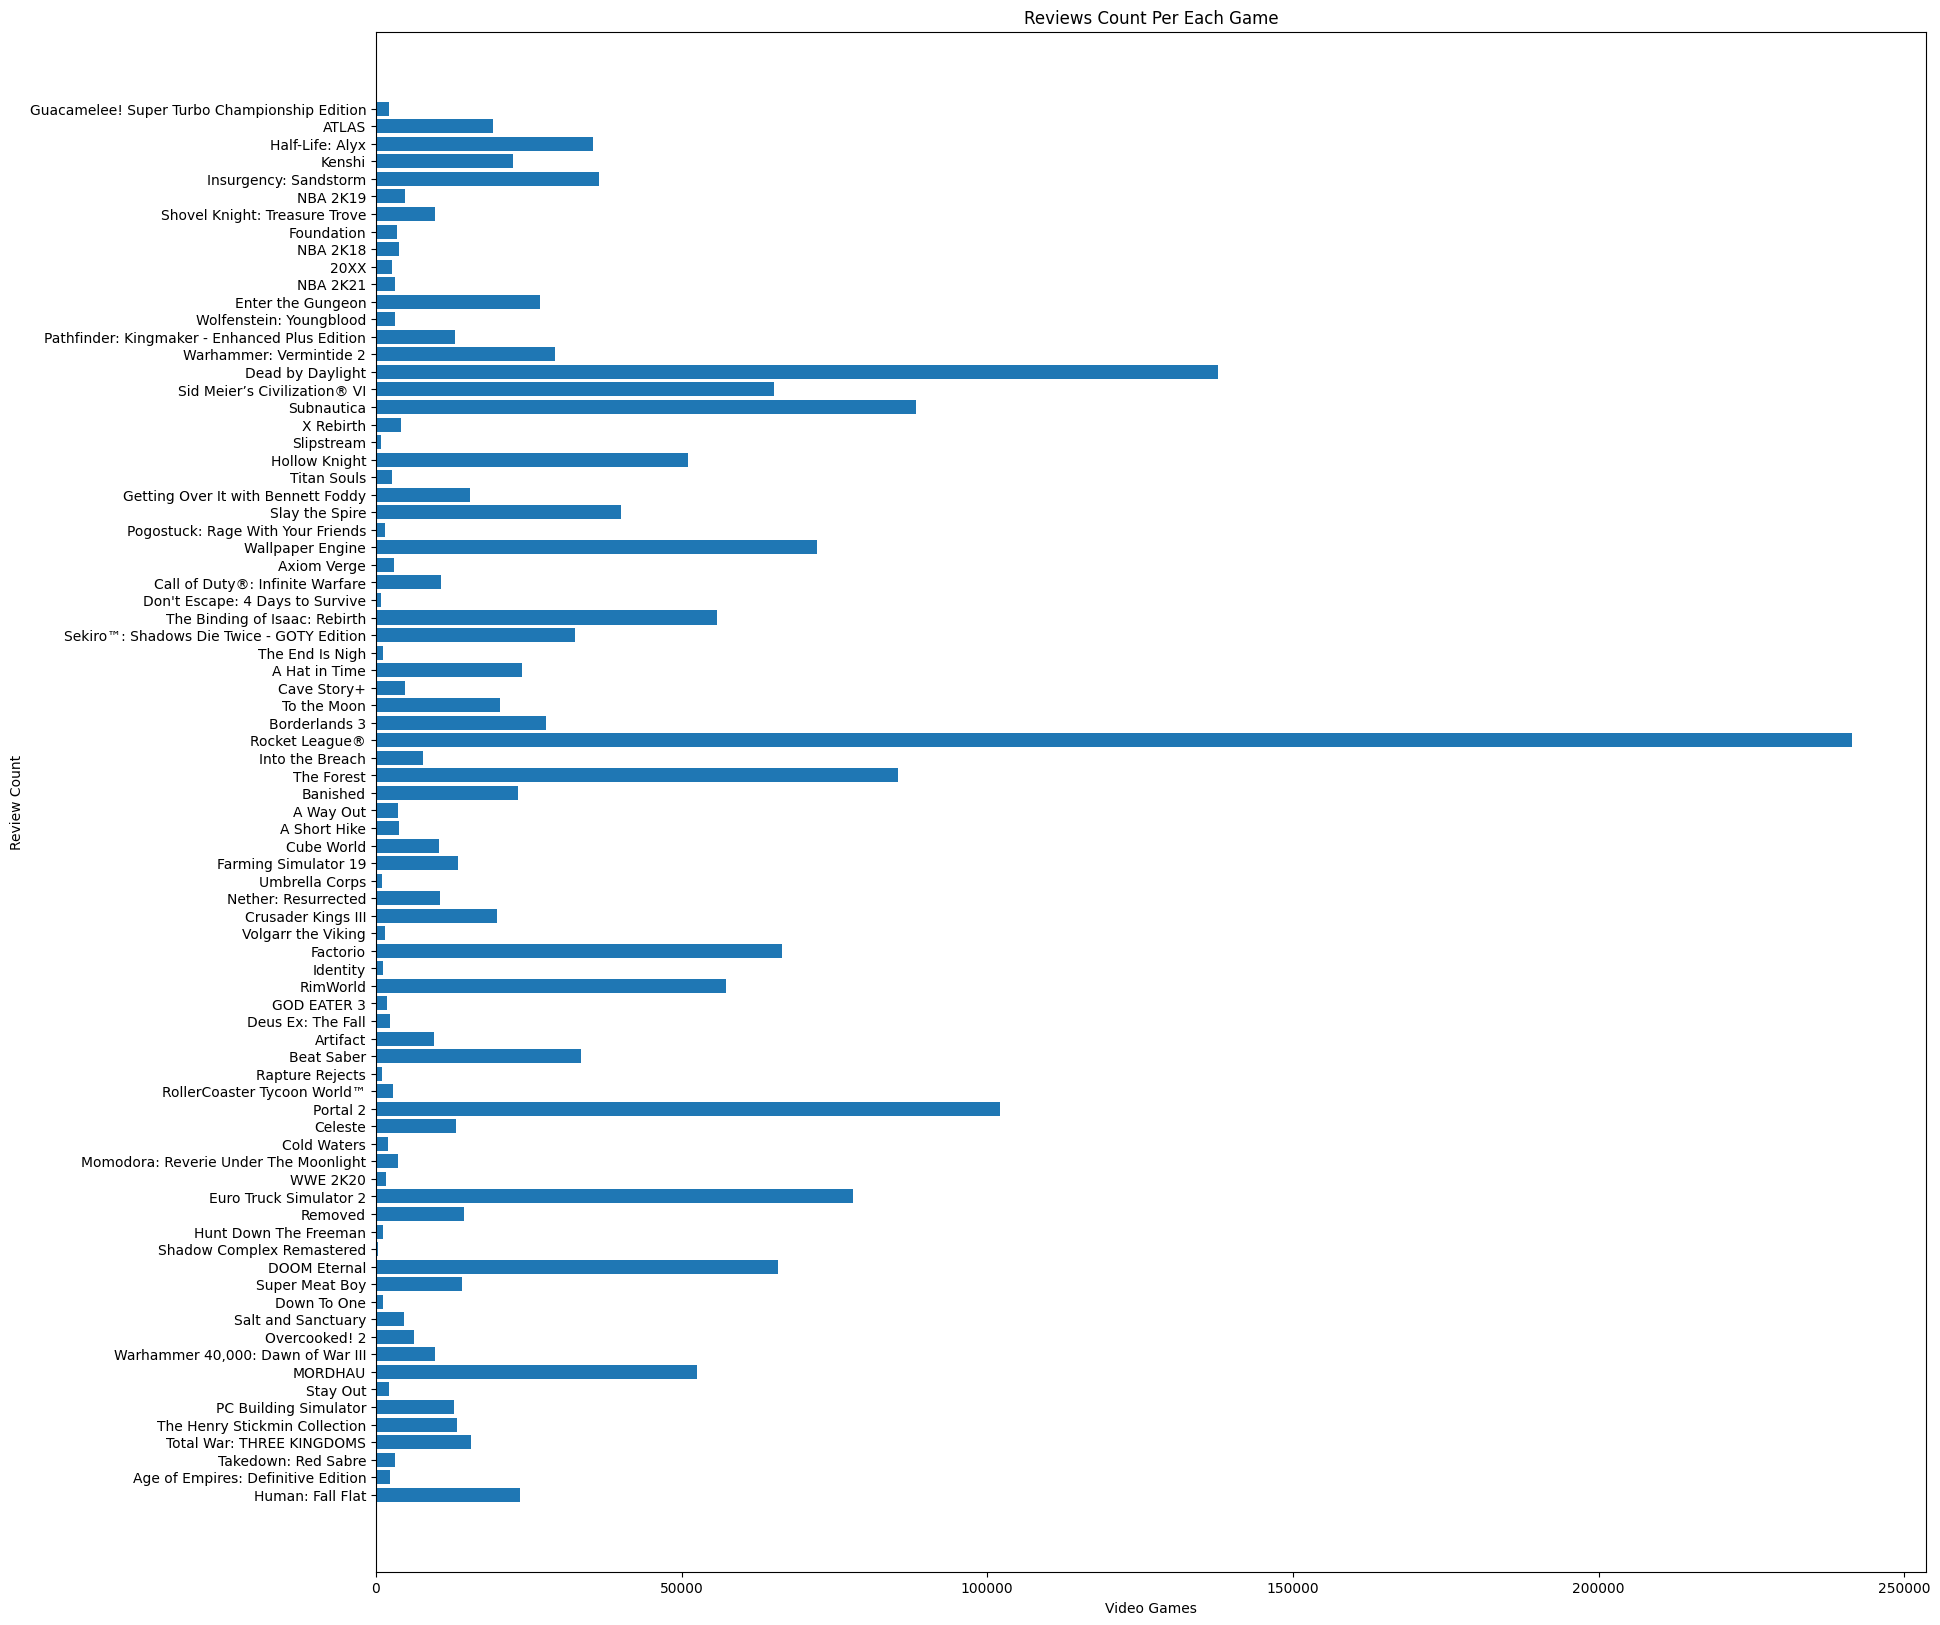

In [ ]:
review_count_per_game_results = review_count_per_game.collect()
games = [row["game_name"] for row in review_count_per_game_results]
review_count = [row["reviews_count_per_game"] for row in review_count_per_game_results]

plt.figure(figsize=(20, 20))

plt.barh(games, review_count)
plt.xlabel("Video Games")
plt.ylabel("Review Count")
plt.title("Reviews Count Per Each Game")

plt.show()

### Data Preprocessing

In [ ]:
video_game_reviews_df.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|
+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------

**Casting the Boolean columns to Integers**

In [ ]:
video_game_reviews_df = video_game_reviews_df.withColumn("voted_up", col("voted_up").cast("int"))
video_game_reviews_df = video_game_reviews_df.withColumn("steam_purchase", col("steam_purchase").cast("int"))
video_game_reviews_df = video_game_reviews_df.withColumn("received_for_free", col("received_for_free").cast("int"))
video_game_reviews_df = video_game_reviews_df.withColumn("written_during_early_access", col("written_during_early_access").cast("int"))
video_game_reviews_df.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|
+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------

**Generating a set of features for each game by calculating total reviews and by taking the average of certain columns**

In [ ]:
'''
Calculating Total reviews count per each game and average of voted_up, votes_up, votes_funny, weighted_vote_score, comment_count, steam_purchase, received_for_free,
written_during_early_access, playtime_forever per each game
'''
video_game_reviews_df_features1 = video_game_reviews_df.groupby('game_name').agg(avg('voted_up').alias('recommended'),
                                                                                 avg('votes_up').alias('votes_up'),
                                                                                 avg('votes_funny').alias('votes_funny'),
                                                                                 avg('weighted_vote_score').alias('weighted_vote_score'),
                                                                                 avg('comment_count').alias('comment_count'),
                                                                                 avg('steam_purchase').alias('steam_purchase'),
                                                                                 avg('received_for_free').alias('received_for_free'),
                                                                                 avg('written_during_early_access').alias('written_during_early_access'),
                                                                                 avg('playtime_forever').alias('playtime_forever'),
                                                                                 count('*').alias('total_reviews'))
video_game_reviews_df_features1.show()

+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+--------------------+---------------------------+------------------+-------------+
|           game_name|        recommended|          votes_up|        votes_funny|weighted_vote_score|      comment_count|    steam_purchase|   received_for_free|written_during_early_access|  playtime_forever|total_reviews|
+--------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+--------------------+---------------------------+------------------+-------------+
|    Human: Fall Flat| 0.9477362246410571|0.9404938376180594|0.32878742958790397|0.14054514243103822|0.05679556139087713|0.6578713311592055| 0.04095548684934988|                        0.0| 1605.802168480793|        23611|
|Age of Empires: D...| 0.7986784140969163| 3.692511013215859| 0.9656387665198238|0.21983148331552876|0.10176

**Generating another set of features for each game by considering all the reviews for a particular game and generating TF-IDF vectors**

In [ ]:
# For tokenizing the reviews column
review_tokenizer = Tokenizer(inputCol='review', outputCol='review_tokens')
# For removing the stop words from the tokens
review_stop_words_remover = StopWordsRemover(inputCol='review_tokens', outputCol='review_filtered_tokens')

# Transforming the video game reviews into tokens and removing stop words
video_game_reviews_df = review_tokenizer.transform(video_game_reviews_df)
video_game_reviews_df = review_stop_words_remover.transform(video_game_reviews_df)

# Displaying the results
video_game_reviews_df.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+-------------+--------------------+----------------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|    game_name|       review_tokens|review_filtered_tokens|
+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+--

In [ ]:
# Merging all the review tokens of all reviews that belongs to a particular game
video_game_reviews_df_features2 = video_game_reviews_df.select('game_name', 'review_filtered_tokens').rdd \
                        .flatMap(lambda row: [(row[0], token) for token in row[1]])
video_game_reviews_df_features2 = video_game_reviews_df_features2.groupByKey().mapValues(list).toDF(['game_name', 'all_review_tokens'])

In [ ]:
# For calculating Term Frequency Vectors
reviews_tf = HashingTF(inputCol='all_review_tokens', outputCol='reviews_tf_vectors')
video_game_reviews_df_features2 = reviews_tf.transform(video_game_reviews_df_features2)
# For calculating Inverse Document Frequency Vectors
reviews_idf = IDF(inputCol='reviews_tf_vectors', outputCol='reviews_tf_idf_vectors')
video_game_reviews_df_features2 = reviews_idf.fit(video_game_reviews_df_features2).transform(video_game_reviews_df_features2)
video_game_reviews_df_features2 = video_game_reviews_df_features2.select('game_name', 'reviews_tf_idf_vectors')
video_game_reviews_df_features2.show()

+--------------------+----------------------+
|           game_name|reviews_tf_idf_vectors|
+--------------------+----------------------+
|            RimWorld|  (262144,[2,5,6,7,...|
|     Into the Breach|  (262144,[6,21,38,...|
|      Slay the Spire|  (262144,[9,19,89,...|
|          Slipstream|  (262144,[113,161,...|
|         To the Moon|  (262144,[18,22,23...|
|         Cave Story+|  (262144,[23,29,11...|
|          Beat Saber|  (262144,[30,35,53...|
|                20XX|  (262144,[16,113,1...|
|            NBA 2K19|  (262144,[2,161,21...|
|          Foundation|  (262144,[4,23,75,...|
|Sid Meier’s Civil...|  (262144,[2,6,7,11...|
|Farming Simulator 19|  (262144,[15,38,71...|
|         Axiom Verge|  (262144,[6,35,55,...|
|     The End Is Nigh|  (262144,[134,154,...|
|Wolfenstein: Youn...|  (262144,[6,35,41,...|
|     Half-Life: Alyx|  (262144,[1,6,15,1...|
|Getting Over It w...|  (262144,[12,23,33...|
|          The Forest|  (262144,[2,6,16,1...|
|            Identity|  (262144,[3

**Combining both the set of features by doing a inner join on game name**

In [ ]:
video_game_reviews_df = video_game_reviews_df_features1.join(video_game_reviews_df_features2, on='game_name', how='inner')
video_game_reviews_df.show()

+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------------+------------------+-------------+----------------------+
|           game_name|        recommended|          votes_up|        votes_funny|weighted_vote_score|       comment_count|     steam_purchase|   received_for_free|written_during_early_access|  playtime_forever|total_reviews|reviews_tf_idf_vectors|
+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------------+------------------+-------------+----------------------+
|          Beat Saber| 0.9640675744122993|1.3230342937162947| 0.6861424783243453|0.13020567219112014| 0.06200280070315526| 0.9244703989512261|0.009385335041563627|        0.24011560349194053| 5006.962518249263|        33563|  (262144,[30,35,53...|
|     Th

**Assembling all the features with the help of Vector Assembler**

In [ ]:
# Using vector assembler to assemble all the features to a single column
video_game_feature_assembler = VectorAssembler(inputCols = ['recommended', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
                                                            'received_for_free', 'written_during_early_access', 'playtime_forever', 'total_reviews', 'reviews_tf_idf_vectors'], outputCol='video_games_features')
video_game_reviews_df = video_game_feature_assembler.transform(video_game_reviews_df)
video_game_reviews_df.show()

+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------------+------------------+-------------+----------------------+--------------------+
|           game_name|        recommended|          votes_up|        votes_funny|weighted_vote_score|       comment_count|     steam_purchase|   received_for_free|written_during_early_access|  playtime_forever|total_reviews|reviews_tf_idf_vectors|video_games_features|
+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+---------------------------+------------------+-------------+----------------------+--------------------+
|         Axiom Verge| 0.9301786896095301| 1.901058901389808|0.35804103242885504| 0.1892925869675956| 0.11515552614162806| 0.8878226340172072| 0.00727994705493051|                        0.0| 1

**Scaling the features**

In [ ]:
# Using standard scaler to scale the video_game_features
video_game_scaler = StandardScaler().setInputCol('video_games_features').setOutputCol('video_games_scaled_features')
video_game_reviews_df = video_game_scaler.fit(video_game_reviews_df).transform(video_game_reviews_df)
video_game_reviews_df = video_game_reviews_df.select('game_name', 'video_games_scaled_features')
video_game_reviews_df.show()

+--------------------+---------------------------+
|           game_name|video_games_scaled_features|
+--------------------+---------------------------+
|Farming Simulator 19|       (262154,[0,1,2,3,...|
|            NBA 2K19|       (262154,[0,1,2,3,...|
|          Foundation|       (262154,[0,1,2,3,...|
|Sid Meier’s Civil...|       (262154,[0,1,2,3,...|
|                20XX|       (262154,[0,1,2,3,...|
|         Axiom Verge|       (262154,[0,1,2,3,...|
|     The End Is Nigh|       (262154,[0,1,2,3,...|
|Wolfenstein: Youn...|       (262154,[0,1,2,3,...|
|     Half-Life: Alyx|       (262154,[0,1,2,3,...|
|Getting Over It w...|       (262154,[0,1,2,3,...|
|          The Forest|       (262154,[0,1,2,3,...|
|            Identity|       (262154,[0,1,2,3,...|
|            RimWorld|       (262154,[0,1,2,3,...|
|     Into the Breach|       (262154,[0,1,2,3,...|
|      Slay the Spire|       (262154,[0,1,2,3,...|
|         To the Moon|       (262154,[0,1,2,3,...|
|          Slipstream|       (2

### Clustering with K-Means

We will cluster the video games based on two distance measures.


1.   **Euclidean Distance Measure**
2.   **Cosine Distance Measure**



#### Euclidean Distance Metric

**Setting the parameters - Number of Clusters(k) = 3, featuresCol(The input features column name) = video_games_scaled_features and the predictionCol (Cluster number the game belongs to) = video_game_cluster, Distance Metric to Euclidean**

**Since we have set k=3, the number of cluster that will be formed will be 3**

**Since we have set the distance measure to Euclidean, the distance between each feature point and the centroid is calculated based on the Euclidean distance while clustering the feature points**

In [ ]:
# Clustering the video games based on the input feature - video_games_scaled_features
video_game_k_means_euclidean = KMeans(k=3, featuresCol='video_games_scaled_features', predictionCol='video_game_cluster').setDistanceMeasure('euclidean')
video_game_k_means_euclidean = video_game_k_means_euclidean.fit(video_game_reviews_df)

In [ ]:
# Checking the assigned cluster of each game
video_games_cluster_predictions_euclidean = video_game_k_means_euclidean.transform(video_game_reviews_df)
video_games_cluster_predictions_euclidean.select('game_name', 'video_game_cluster').show()

+--------------------+------------------+
|           game_name|video_game_cluster|
+--------------------+------------------+
|         Cave Story+|                 0|
|          Beat Saber|                 0|
|Farming Simulator 19|                 0|
|Sid Meier’s Civil...|                 0|
|          Foundation|                 0|
|            NBA 2K19|                 0|
|     The End Is Nigh|                 0|
|                20XX|                 0|
|Getting Over It w...|                 0|
|         Axiom Verge|                 0|
|Wolfenstein: Youn...|                 0|
|            RimWorld|                 0|
|            Identity|                 0|
|     Half-Life: Alyx|                 0|
|     Into the Breach|                 0|
|          The Forest|                 0|
|          Slipstream|                 0|
|         To the Moon|                 0|
|      Slay the Spire|                 0|
|             Removed|                 0|
+--------------------+------------

#### Analysing the results - Euclidean Distance Metric

**Displaying the clustered video games**

In [ ]:
clustered_games_euclidean = video_games_cluster_predictions_euclidean.groupby('video_game_cluster').agg(collect_list('game_name').alias('games'))
clustered_games_euclidean.show(truncate=False)

+------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Cosine Distance Metric

**Setting the parameters - Number of Clusters(k) = 3, featuresCol(The input features column name) = video_games_scaled_features and the predictionCol (Cluster number the game belongs to) = video_game_cluster, Distance Metric to Cosine**

**Since we have set the distance measure to Euclidean, the distance between each feature point and the centroid is calculated based on the Euclidean distance while clustering the feature points**

In [ ]:
video_game_k_means_cosine = KMeans(k=3, featuresCol='video_games_scaled_features', predictionCol='video_game_cluster').setDistanceMeasure('cosine')
video_game_k_means_cosine = video_game_k_means_cosine.fit(video_game_reviews_df)

In [ ]:
video_games_cluster_predictions_cosine = video_game_k_means_cosine.transform(video_game_reviews_df)
video_games_cluster_predictions_cosine.select('game_name', 'video_game_cluster').show()

+--------------------+------------------+
|           game_name|video_game_cluster|
+--------------------+------------------+
|Farming Simulator 19|                 2|
|            NBA 2K19|                 2|
|     The End Is Nigh|                 1|
|                20XX|                 1|
|Getting Over It w...|                 0|
|         Axiom Verge|                 1|
|Wolfenstein: Youn...|                 1|
|     Half-Life: Alyx|                 1|
|            RimWorld|                 1|
|          The Forest|                 0|
|     Into the Breach|                 1|
|            Identity|                 0|
|      Slay the Spire|                 1|
|         Cave Story+|                 1|
|          Slipstream|                 2|
|         To the Moon|                 1|
|          Beat Saber|                 2|
|          Foundation|                 1|
|Sid Meier’s Civil...|                 1|
|       Overcooked! 2|                 2|
+--------------------+------------

#### Analysing the results - Cosine Distance Metric

**Displaying the clustered video games**

In [ ]:
clustered_games_cosine = video_games_cluster_predictions_cosine.groupby('video_game_cluster').agg(collect_list('game_name').alias('games'))
clustered_games_cosine.show(truncate=False)

+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|video_game_cluster|games                                                                                                                                                                                                                             


# **Task 2 - One multi classifier incorporating Ensemble techniques [25 marks]**


### We will be classifying the users playtime for a particular game based on certain features

**We want to classify the users playtime into very_low_playtime/low_playtime/good_playtime/high_playtime. In the current dataset the column playtime_forever denotes the total playtime of user for a particular game. We will form a new column playtime_category based on playtime_forever column based on the below threshold.**

<100 - very_low_playtime

<1000 - low_playtime

<10000 - good_playtime

.>10000 - high_playtime

Then we will classify the column playtime_category with multi classifier incorporating ensemble techniques

In [ ]:
# Function to map continious value (playtime) to discrete value (playtime_category)
def categorize_playtime(playtime):
    if playtime < 100:
        return "very_low_playtime"
    elif playtime < 1000:
        return "low_playtime"
    elif playtime < 10000:
        return "good_playtime"
    else:
        return "high_playtime"

# Registering the function categorize_playtime as an user defined function
categorize_playtime_udf = udf(categorize_playtime, StringType())

# Create a new column called "playtime_category" by applying the categorize_playtime_udf to the "playtime_forever" column
video_game_reviews_df2 = video_game_reviews_df2.withColumn("playtime_category", categorize_playtime_udf("playtime_forever"))

video_game_reviews_df2.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+-----------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|playtime_category|
+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+--

### Data Visualisation

**Records per playtime category**

In [ ]:
user_game_per_playtime_category = video_game_reviews_df2.groupBy("playtime_category").agg(count("*").alias("user_game_per_playtime_category"))
user_game_per_playtime_category.show()

+-----------------+-------------------------------+
|playtime_category|user_game_per_playtime_category|
+-----------------+-------------------------------+
|    high_playtime|                         533596|
|    good_playtime|                         943824|
|very_low_playtime|                          56126|
|     low_playtime|                         382587|
+-----------------+-------------------------------+



**Plotting the results**

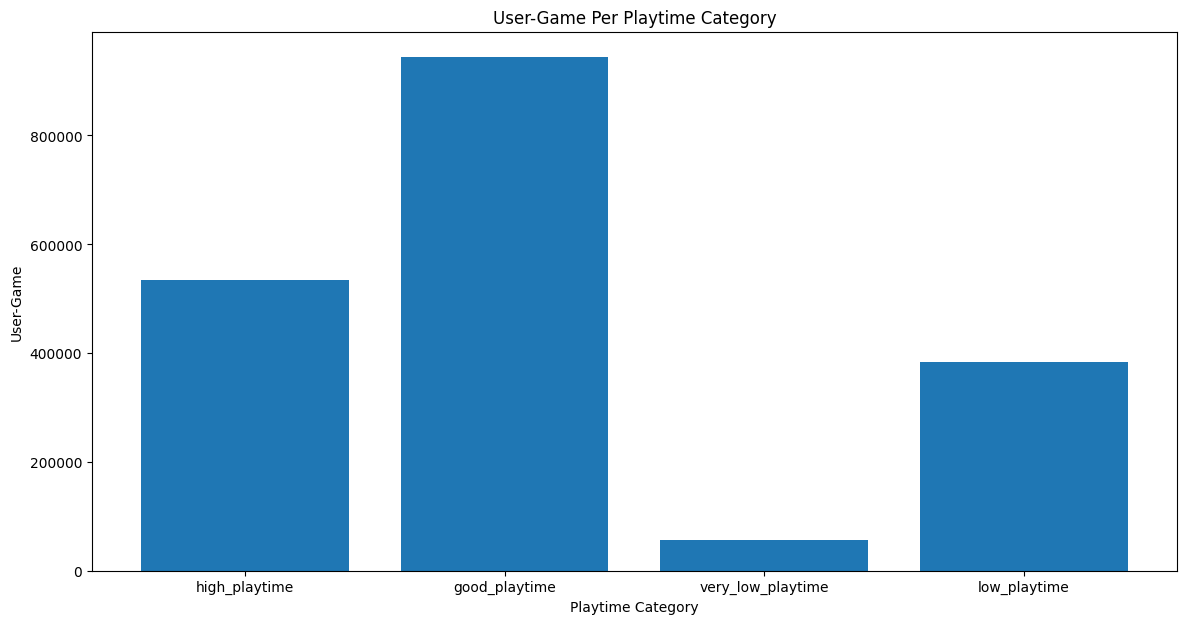

In [ ]:
user_game_per_playtime_category_results = user_game_per_playtime_category.collect()
playtime_categories = [row["playtime_category"] for row in user_game_per_playtime_category_results]
user_game_count = [row["user_game_per_playtime_category"] for row in user_game_per_playtime_category_results]

plt.figure(figsize=(14, 7))

plt.bar(playtime_categories, user_game_count)
plt.xlabel("Playtime Category")
plt.ylabel("User-Game")
plt.title("User-Game Per Playtime Category")

plt.show()

### Feature Selection

Based on the domain knowledge, the playtime of an user for a particular game mainly depends on the below features

In [ ]:
input_features = ['user_review_vectors', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'num_games_owned', 'num_reviews', 'playtime_last_two_weeks', 'steam_purchase', 'received_for_free', 'written_during_early_access']
target_feature = 'playtime_category'

### Data Preprocessing

**Converting the reviews column (string) into numerical representation by training a Word2Vec model on reviews to learn the word embeddings and transforming the reviews**

In [ ]:
# For tokenizing the user reviews
video_game_review_tokenizer = Tokenizer().setInputCol('review').setOutputCol('user_review_tokens')
# For removing stop words from the tokens
video_game_reviews_stop_words_remover = StopWordsRemover().setInputCol('user_review_tokens').setOutputCol('user_review_filtered_tokens')
# For training Word2Vec model on the users review tokens
video_game_review_word2Vec = Word2Vec().setInputCol('user_review_filtered_tokens').setOutputCol('user_review_vectors')
# Assembling all the input features
video_game_vector_assembler = VectorAssembler().setInputCols(input_features).setOutputCol('user_game_features')

**Scaling is not required, since we will be using Random Forset Classifier for incorporating Ensemble techniques**

Creating two pipelines

1) **For transforming input features**

2) **For transforming target feature to numerical value to train the ML model**

In [ ]:
# Defining the stages for input feature pipeline
input_feature_pipeline_stages = [video_game_review_tokenizer, video_game_reviews_stop_words_remover, video_game_review_word2Vec, video_game_vector_assembler]

**Since we are encoding only the target feature to numerical value, we don't have to worry about the order present in the target feature category**

In [ ]:
# To encode target feature playtime_category to numerical value
playtime_category_indexer = StringIndexer(inputCol="playtime_category", outputCol="playtime_index")

In [ ]:
# Defining the target feature pipeline stages
target_feature_pipeline_stages = [playtime_category_indexer]

In [ ]:
# Fitting the pipeline on the input dataset
video_game_reviews_input_feature_pipeline = Pipeline(stages=input_feature_pipeline_stages)
video_game_reviews_target_feature_pipeline = Pipeline(stages=target_feature_pipeline_stages)
video_game_reviews_input_feature_pipeline = video_game_reviews_input_feature_pipeline.fit(video_game_reviews_df2)
video_game_reviews_target_feature_pipeline = video_game_reviews_target_feature_pipeline.fit(video_game_reviews_df2)

**Train-Test Split(Splitting them in a stratified way to preserve the class ratios in the training and test set)**

In [ ]:
# Train, test split with fractions of 0.85 per each class
video_game_reviews_train_df = video_game_reviews_df2.sampleBy('playtime_category', fractions = {'low_playtime':0.85, 'very_low_playtime':0.85,
                                                                                                'good_playtime': 0.85, 'high_playtime':0.85})
video_game_reviews_test_df = video_game_reviews_df2.subtract(video_game_reviews_train_df)

In [ ]:
# Checking the training data
video_game_reviews_train_df.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+-----------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|playtime_category|
+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+--

In [ ]:
# Checking the testing data
video_game_reviews_test_df.show()

+-----+-----+----------------+--------+-----------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+---------+-----------------+
|appid|index|recommendationid|language|                             review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|game_name|playtime_category|
+-----+-----+----------------+--------+-----------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+--------------------------

**Transforming the input features**

In [ ]:
# Transforming the input features with the help of the above defined pipelines
video_game_reviews_train_transformed = video_game_reviews_input_feature_pipeline.transform(video_game_reviews_train_df)
video_game_reviews_train_transformed = video_game_reviews_target_feature_pipeline.transform(video_game_reviews_train_transformed)
video_game_reviews_train_transformed.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+-----------------+--------------------+---------------------------+--------------------+--------------------+--------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|playtime_category|  user_review_tokens|user_review_filtered_tokens| user_review_vectors|  user_game_features|playtime_index|
+------+-------+----------------

### Training the model

**Since the dataset is imbalanced, Random Forest can be biased towards the majority class. Hence, using class weights to address this issue**

In [ ]:
# To calculate class weights per each class
playtime_class_counts = video_game_reviews_train_transformed.groupBy("playtime_index").count()
reviews_total_count = video_game_reviews_train_transformed.count()
playtime_class_weights = (
    playtime_class_counts
    .withColumn("playtime_class_weights", reviews_total_count / (col("count") * playtime_class_counts.count()))
    .select("playtime_index", "playtime_class_weights")
    .rdd
    .collectAsMap()
)

# Define UDF to apply class weights
playtime_class_weights_udf = udf(lambda x: playtime_class_weights[x], DoubleType())
video_game_reviews_train_transformed = video_game_reviews_train_transformed.withColumn("playtime_class_weights", playtime_class_weights_udf(col("playtime_index")))
video_game_reviews_train_transformed.show()

+------+-------+----------------+--------+--------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+---------------+-----------+----------------+-----------------------+------------------+-----------+----------------+-----------------+--------------------+---------------------------+--------------------+--------------------+--------------+----------------------+
| appid|  index|recommendationid|language|              review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|          steamid|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|last_played|       game_name|playtime_category|  user_review_tokens|user_review_filtered_tokens| user_review_vectors|  user_game_features|playtime_index|playtime_c

Using **RandomForestClassifier** for incorporating Ensemble techniques.
RandomForestClassifier uses the **Bagging** technique by building **multiple decision trees** for predicting the output and it finally takes the **majority-voted** output predicted by the decision trees.

In the below code, we are setting the parameters

**numTrees=50** - It means that,  it builds 50 decision trees for predicting the output.

**maxDepth=5** - It indicates the maximum depth of each decision tree. Setting this to a high value leads to overfitting

In [ ]:
video_game_reviews_model = RandomForestClassifier(numTrees=50, maxDepth=5).setLabelCol('playtime_index').setFeaturesCol('user_game_features').setWeightCol('playtime_class_weights')
video_game_reviews_model = video_game_reviews_model.fit(video_game_reviews_train_transformed)

### Prediction of results on the Test Set

In [ ]:
video_game_reviews_test_transformed = video_game_reviews_input_feature_pipeline.transform(video_game_reviews_test_df)
video_game_reviews_test_transformed = video_game_reviews_target_feature_pipeline.transform(video_game_reviews_test_transformed)
video_game_reviews_test_predictions = video_game_reviews_model.transform(video_game_reviews_test_transformed)

In [ ]:
video_game_reviews_test_predictions = video_game_reviews_test_predictions.select('playtime_index', 'prediction')
video_game_reviews_test_predictions.show()

+--------------+----------+
|playtime_index|prediction|
+--------------+----------+
|           1.0|       1.0|
|           1.0|       1.0|
|           1.0|       2.0|
|           1.0|       2.0|
|           2.0|       2.0|
|           1.0|       1.0|
|           1.0|       1.0|
|           1.0|       1.0|
|           1.0|       1.0|
|           1.0|       0.0|
|           1.0|       1.0|
|           1.0|       1.0|
|           1.0|       2.0|
|           1.0|       2.0|
|           1.0|       1.0|
|           0.0|       1.0|
|           1.0|       1.0|
|           0.0|       0.0|
|           0.0|       1.0|
|           1.0|       1.0|
+--------------+----------+
only showing top 20 rows



**Converting numerical value back to categorical value**

In [ ]:
# For converting numerical value back to categorical value
labels = video_game_reviews_target_feature_pipeline.stages[0].labels
label_map = dict()
for i, label in enumerate(labels):
    label_map[i] = label
label_map

{0: 'good_playtime',
 1: 'low_playtime',
 2: 'high_playtime',
 3: 'very_low_playtime'}

In [ ]:
def convert_indices_back_to_categories(playtime_indices):
  global label_map
  return label_map[int(playtime_indices)]

playtime_udf = udf(convert_indices_back_to_categories, StringType())
video_game_reviews_test_predictions = video_game_reviews_test_predictions.withColumn("playtime_category", playtime_udf("playtime_index"))
video_game_reviews_test_predictions = video_game_reviews_test_predictions.withColumn("prediction_category", playtime_udf("prediction"))
video_game_reviews_test_predictions.show()

+--------------+----------+-----------------+-------------------+
|playtime_index|prediction|playtime_category|prediction_category|
+--------------+----------+-----------------+-------------------+
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       2.0|     low_playtime|      high_playtime|
|           1.0|       2.0|     low_playtime|      high_playtime|
|           2.0|       2.0|    high_playtime|      high_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       0.0|     low_playtime|      good_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|           1.0|       1.0|     low_playtime|       low_playtime|
|         


# **Task 3 - Performance Measurements [10 marks]**


## For Clustering

A good clustering solution should have **High Intra-Cluster Density and Low Inter-Cluster Density** or **Low Intra-Cluster Distance and High Inter-Cluster Distance**.

Silhouette score is calculated using the **Intra-Cluster distance (A)** and **Inter-Cluster distance (B)**. **A good Silhouette score indicate better clustering.**

#### Silhouette Score

In [ ]:
clustered_games_evaluator_euclidean = ClusteringEvaluator(featuresCol='video_games_scaled_features', predictionCol='video_game_cluster', metricName='silhouette')
silhouette_score_euclidean_k_3 = clustered_games_evaluator_euclidean.evaluate(video_games_cluster_predictions_euclidean)
clustered_games_evaluator_cosine = ClusteringEvaluator(featuresCol='video_games_scaled_features', predictionCol='video_game_cluster', metricName='silhouette').setDistanceMeasure('cosine')
silhouette_score_cosine_k_3 = clustered_games_evaluator_cosine.evaluate(video_games_cluster_predictions_cosine)
print('Silhouette score for euclidean distance metric with K=3 : ', silhouette_score_euclidean_k_3)
print('Silhouette score for cosine distance metric with K=3 : ', silhouette_score_cosine_k_3)

Silhouette score for euclidean distance metric with K=3 :  0.7551253314479744
Silhouette score for cosine distance metric with K=3 :  -0.000709089297557515


We observe that the Euclidean distance metric has a better Silhouette score.

#### Choosing the right value of K using Elbow Graph

**For choosing the right number of clusters, we will use a technique called elbow graph where we plot the WSSSE(Within Set Sum of Squared Error) values with respect to number of clusters and choose the elbow point(the point where the WSSSE tends to decrease at a slower rate, and the graph starts to flatten outt) to get the optimal number of clusters.**

In [ ]:
# Number of clusters ranging from values ranging from 2 to 11
K_values = range(2, 11)
clustered_games_wssse_values = []
# Clustering with each k value
for K in K_values:
  video_game_k_means = KMeans(k=K, featuresCol='video_games_scaled_features', predictionCol='video_game_cluster')
  video_game_k_means = video_game_k_means.fit(video_game_reviews_df)
  # Storing the wsse distance
  clustered_games_wssse_values.append(video_game_k_means.summary.trainingCost)
# Checking the wssse values
clustered_games_wssse_values

[3469944.0275523732,
 3201933.121385224,
 3073907.1401605997,
 2978306.8402899494,
 2988906.081427346,
 2782563.280080792,
 2725039.3292972306,
 2522196.182315903,
 2570948.6395767843]

**Plotting the elbow graph**

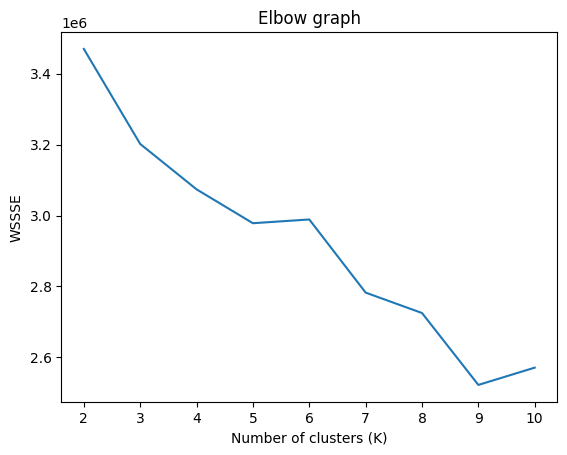

In [ ]:
plt.plot(K_values, clustered_games_wssse_values)
plt.xlabel('Number of clusters (K)')
plt.ylabel('WSSSE')
plt.title('Elbow graph')
plt.show()

**K=7 seems to be the elbow point. So the optimal number of clusters for this task is 7**

## For Multi Classifier

#### Confusion Matrix

In [ ]:
# Generating confusion matrix
user_game_playtime_metrics = MulticlassMetrics(video_game_reviews_test_predictions.select('prediction', 'playtime_index').rdd.map(tuple))
user_game_confusion_matrix = user_game_playtime_metrics.confusionMatrix().toArray()
playtime_classes = [str(i) for i in range(user_game_confusion_matrix.shape[0])]
for i in range(len(playtime_classes)):
  playtime_classes[i] = convert_indices_back_to_categories(i)

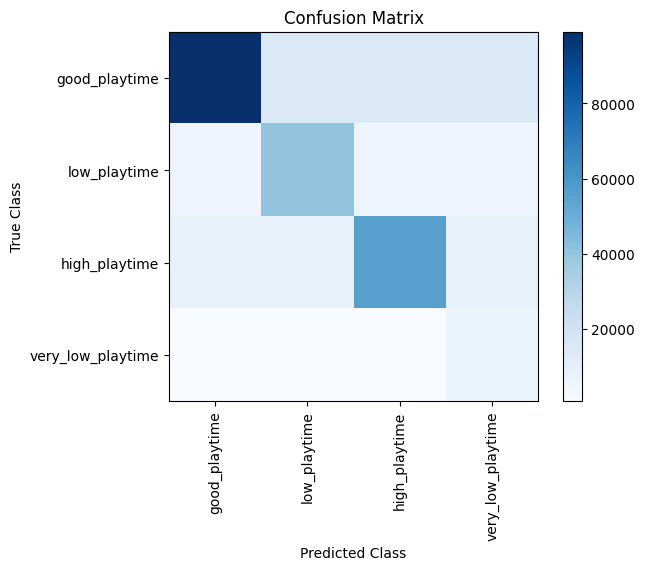

In [ ]:
# Plotting the confusion matrix
plt.imshow(user_game_confusion_matrix, cmap="Blues")
plt.colorbar()
plt.xticks(np.arange(len(playtime_classes)), playtime_classes, rotation=90)
plt.yticks(np.arange(len(playtime_classes)), playtime_classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

#### Precision

In [ ]:
# Calculating the Weighted Precision for all classes
user_game_precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="playtime_index", metricName="weightedPrecision")
precision = user_game_precision_evaluator.evaluate(video_game_reviews_test_predictions)
print("Precision = {:.2f}%".format(precision * 100))

Precision = 76.44%


#### Recall

In [ ]:
# Calculating the Weighted Recall for all classes
user_game_recall_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="playtime_index", metricName="weightedRecall")
recall = user_game_recall_evaluator.evaluate(video_game_reviews_test_predictions)
print("Recall = {:.2f}%".format(recall * 100))

Recall = 69.97%


#### F1-Score

In [ ]:
# Calculating the F1-Score
user_game_f1_score_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="playtime_index", metricName="f1")
f1_score = user_game_f1_score_evaluator.evaluate(video_game_reviews_test_predictions)
print("F1-Score = {:.2f}%".format(f1_score * 100))

F1-Score = 72.25%


#### Accuracy

In [ ]:
# Calculating the accuracy
user_game_accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="playtime_index", metricName="accuracy")
accuracy = user_game_accuracy_evaluator.evaluate(video_game_reviews_test_predictions)
print("Accuracy = {:.2f}%".format(accuracy * 100))

Accuracy = 69.97%


---

# **Section 2: Data Streaming Application [30 marks]**

---

## **Airstream - Spark Streaming at Airbnb**

### Overview

Airbnb is a popular online marketplace where homes can be rent by people for short-term stays who are planning a vacation. Airbnb offers a lot of accommodations ranging from shared rooms to entire homes. Airbnb consists of two types of users.

1) Hosts - Who rent their houses for a certain period for a certain amount of money

2) Guests - Who can book these houses for short-term stays if they are planning for a vacation or tourism. Apart from house renting, guests can also book experiences on Airbnb, which provides a unique way to experience local culture.


Airbnb's real-time streaming application involves logging event ingestion of various events performed by the user in real-time for generating various real-time dashboards to govern various business decisions and for real-time ranking of places based on user's search results. These events emitted from the Hosts and Guests either from the Airbnb mobile app or the Airbnb website with key information, event type, and context of the event.
For an example when a particular user searches for 'tree house near Cyprus then an event is generated with the key as 'userId', event type as 'Search Event', and context as 'location, check-in, and check-out dates'. Similarly, when a user books a particular house, another event is generated with a key as 'userId' type as 'Payment Event' context as 'Booking Information'. These events will be anonymized by stripping off all the personal user information such as username, first name, last name, and email.

### Legal Issues



*   Compliance with local regulations: Airbnb has faced legal challenges in various cities alll over the world where short-term rentals are not permitted, or there are restrictions on the number of days a property can be rented out. Compliance with local regulations is critical to ensure that the platform operates within the legal framework of different countries.
*   Data privacy: Airbnb collects and processes a vast amount of data on its users, including personal information, payment details, and booking history. It is essential to comply with data privacy regulations to ensure that this data is collected, stored, and processed securely and transparently. For the real-time streaming of user's events for generating real-time dashboards, Airbnb anonymises the user's information by stripping off all their personal information before the data is sent to Kafka for stream processing
*   Liability: As a platform, Airbnb is not liable for any accidents, injuries, or damages that occur on a host's property. However, hosts are responsible for ensuring that their properties are safe and comply with local regulations. Airbnb must ensure that it provides accurate information to guests and hosts about liability and insurance coverage.

### Social Issues



*   Housing affordability: Airbnb has been accused of driving up housing costs in some cities, as landlords convert long-term rentals into short-term rentals to make a higher profit. This can harm the availability and affordability of housing for locals.
*   Impact on local communities: Airbnb can have a significant impact on the character and culture of a neighborhood, as short-term rentals can change the demographics of an area and affect the availability of local services and amenities.
*   Discrimination: Airbnb has faced criticism for allowing hosts to discriminate against guests based on race, gender, sexual orientation, and other characteristics. The platform must ensure that its policies and practices are inclusive and do not allow discrimination.





### Ethical Issues



*   Fairness and transparency: Airbnb must ensure that its platform is fair and transparent for all users. This includes providing accurate information about listings, fees, and other charges, as well as ensuring that hosts and guests are treated equally and have access to the same opportunities and services.
*   Environmental impact: Airbnb can have a negative impact on the environment as it promotes short-term travel and can contribute to over-tourism in some areas. The platform must consider the environmental impact of its operations and take steps to mitigate any negative effects.
*   Exploitation: There have been instances where hosts have been exploited by Airbnb, such as when the platform has taken a significant percentage of their earnings or when hosts have been unfairly penalized for guest behavior. Airbnb must ensure that it operates ethically and does not exploit its users.

### Functionality

Airstream is designed to work with Spark streaming to provide a framework for collecting, processing, and analyzing streaming data. It provides an easy-to-use interface for defining data pipelines, which allows developers to focus on the business logic of their applications rather than the underlying infrastructure.
The application's functionality involves ingesting events that are generated when users perform various activities, such as searching for a place, booking a house, or leaving a review. These events are then anonymized by stripping off any personal user information and are sent to Kafka. Depending on the type of event these events are sent to their corresponding Kafka topic. Then depending on whether an order is required for a particular event type, these events will be stored on a particular partition in the topic based on the hash value generated by the event. Then these events will be read by a spark from the Kafka partition and are processed parallelly by each node. Few operations such as transforming data will be done statelessly. whereas other operations will be processed by maintaining a state in the HBase to persist the state that can be accessed by all the streaming jobs. The state information is stored in HBase as a key-value pair and can be accessed by all the streaming jobs while processing data. For operations such as generating total payments per location, a tumbling window of a non-overlapping period is used and total payments were calculated for each time and the results are stored in the Druid (A NoSQL Database on top of HDFS). These results will be queried from Druid by the real-time dashboards to display the real-time analytics. Similarly for real-time ranking of places sliding window is used with the watermark typically being set to month. The ranking is calculated based on the user events related to a particular place and the results will be sent to HBase and Druid. These results will be queried from Druid by the real-time dashboards to display the real-time analytics. Also whenever a particular user searches for a particular place then these results will be queried from the HBase and appear in the search results in the order of ranking. These results were also cached in the front-facing server to further reduce the latency and improve the user experience.
The model used for low latency processing in Spark involves micro-batch processing, which allows Spark to process small batches of data in real-time, rather than processing data one event at a time. This approach reduces the end-to-end latency of the application and improves its fault tolerance by allowing it to recover from failures quickly.
The micro-batch model involves dividing the streaming data into small batches, which are processed by Spark in parallel. Each batch is processed independently, and the results are aggregated to generate the final output. This approach allows the application to process data at a high rate while ensuring low latency and fault tolerance.
To ensure fault tolerance, the application uses Spark's resilient distributed datasets (RDDs), which are a fault-tolerant collection of elements that can be processed in parallel. A checkpoint-based mechanism is used and all the intermediate results were checkpointed so that if a node fails, other nodes in the cluster will start processing from the same state based on the checkpoint progress, ensuring that data processing continues without interruption.

### Break down of streaming application into different layers

#### Data source layer

The data source layer includes the Airbnb mobile app and the Airbnb website. These sources emit various events related to user activities, which are then ingested into the system for processing in real time. The events capture various user activities, such as searching for a place, booking a house, leaving a review, and more. To ensure the security and privacy of user data, the data source layer anonymizes the events by stripping off any personal information, such as usernames, email addresses, and more. This anonymization process ensures that user privacy is protected while still allowing the application to generate meaningful insights from the data.

#### Streaming layer

Kafka is used as the streaming layer which is an open-source distributed event streaming platform used for streaming application and building real-time data pipelines. It is designed to handle high-volume data streams with low latency and high throughput. Kafka allows multiple producers to write data to the same stream, and multiple consumers to read from the same stream simultaneously, making it highly scalable and fault-tolerant. It provides features such as low latency, high-throughput messaging, data retention, replication, and fault tolerance, which make it ideal for use cases such as log aggregation, stream processing, and event-driven architectures.


As per the findings, 10+ Kafka clusters were deployed on AWS with 500+ Brokers and 3000+ topics.


Multiple user events from the data source layer are sent to Kafka. A load balancer is used in front of the Kafka clusters to distribute the user events evenly across the cluster. Then depending on the event type they will be sent to a particular Kafka topic (For example all the payments events will go to the Kafka topic - Payment, All the Search events will go to the Kafka topic - Search, etc..).The events which don't require ordering (For example Views) will be evenly distributed across all the partitions in a particular Kafka topic. For the events which require ordering (For example Search results ordered by time), these will be distributed to a particular partition inside a Kafka topic based on the Hash mechanism by mapping the userId to the partition id inside a particular Kafka topic to preserve the order of events for a particular user inside the particular Kafka partition. Consistent hashing is used so that the system can be scaled by adding more partitions in the future only by remapping a few keys.

#### Stream processing layer

Apache Spark is used as the stream processing layer to process the events ingested by Kafka. Spark Streaming is a scalable and fault-tolerant stream processing system that can process large-scale, real-time data streams.


For the low latency, instead of processing one event at a time, it uses a micro-batch model by dividing the streams into small data which are processed parallelly by the spark. Since the parallelism of spark is determined by the total number of partitions in the Kafka topic, this limits the performance of the spark processing. To solve this issue, Airbnb uses Balanced Spark Kafka Reader for a particular topic consisting of events where the ordering of events is not a requirement. Since the ordering of events is not important for these events belonging to a particular topic, as per the balanced Kafka reader it pre-computes the mean event size for these topics, and the number of splits is calculated to specify the desired parallelism. For each Kafka partition, it computes from the current offset to latest offset range to read and applies the maximum rate per partition constraint if set and these offset range subsets are assigned to splits evenly with the help of a balanced partition algorithm. For the particular topics, in which ordering in partitions is important spark's parallelism is limited to the number of partitions, and hence for these topics, spark parallelism can be increased only by increasing the number of partitions in the Kafka topic.


Two types of event types will be processed by the spark. Stateless events involve the transformation of the data stream. These events will be processed and written to another Kafka source as a sink and they will be further processed. For the stateful events, storing the state inside the memory will lead to out of memory errors, and also a lot of times other spark jobs need to access the state which is processed by the different streaming jobs. To solve this issue, a global state is stored in the form of key, value pairs in HBase which can be accessed and updated by all the spark streaming jobs. For operations such as generating total payments per location, a tumbling window of non-overlapping time is used and total payments were calculated for each time and the results are stored in the Druid (A NoSQL Database on top of HDFS). For real-time ranking of places sliding window is used with a watermark typically being set to month. The ranking is calculated based on the user events related to a particular place and the results will be sent to HBase. These results will be served to the users in the order of ranking whenever users perform search queries. These rankings are also cached in the front-facing server to reduce the latency.


The whole system is fault tolerant by maintaining checkpoints by the spark streaming jobs. Whenever a particular streaming job has failed, another can take its place and can resume from the same checkpoint.


For the streaming jobs, the sinks are Druid or can be another Kafka source (For example streaming jobs that perform transformations of data will write the output to another Kafka source and they will be further processed by other spark streaming jobs)

#### Presentation layer

Real-time dashboards are used as the Presentation layer. Spark jobs process the data and write output to the sinks. Here, Druid is used as a sink. Druid is a NoSQL database on top of HDFS. These real-time dashboards get the final results by querying the Druid database and displaying them.

---

# **Section 3: Convert ipynb to HTML for Turnitin submission [10 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# convert ipynb to html and submit this HTML file

!jupyter nbconvert --to html /content/Group01_CRWK_CN7030.ipynb

[NbConvertApp] Converting notebook /content/Group01_CRWK_CN7030.ipynb to html
[NbConvertApp] Writing 1302592 bytes to /content/Group01_CRWK_CN7030.html
